<a href="https://colab.research.google.com/github/vedthebest/Pneumonia-Detection/blob/main/unet_CV1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.0 MB 5.3 MB/s 


In [3]:
# Imports
import os
import cv2
import glob
import time
import pydicom
import skimage
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import feature, filters
%matplotlib inline

from functools import partial
from collections import defaultdict
from joblib import Parallel, delayed
from lightgbm import LGBMClassifier
from tqdm import tqdm

# Tensorflow / Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.applications.vgg16 import VGG16
from keras import models
from keras import layers

# sklearn
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

sns.set_style('whitegrid')
np.warnings.filterwarnings('ignore')

In [4]:
#load merged_df.pkl. This contains all merged data from both CSV files for training.
merged_df = pd.read_pickle('/content/drive/MyDrive/Colab/capstoneCV1/pklfiles/merged_df.pkl')

In [5]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype   
---  ------              --------------  -----   
 0   patientId           30227 non-null  object  
 1   x                   9555 non-null   float64 
 2   y                   9555 non-null   float64 
 3   width               9555 non-null   float64 
 4   height              9555 non-null   float64 
 5   Target              30227 non-null  int64   
 6   class               30227 non-null  object  
 7   y_max               9555 non-null   float64 
 8   x_max               9555 non-null   float64 
 9   Modality            30227 non-null  object  
 10  ConversionType      30227 non-null  object  
 11  PatientSex          30227 non-null  object  
 12  PatientAge          30227 non-null  int64   
 13  Body Part Examined  30227 non-null  object  
 14  ViewPosition        30227 non-null  object  
 15  Rows                30227 non-null  

In [6]:
cd "/content/drive/MyDrive/Colab/capstoneCV1/data"

/content/drive/MyDrive/Colab/capstoneCV1/data


In [7]:
# Reference image directories
trainImagesPath = "stage_2_train_images"
testImagesPath = "stage_2_test_images"

labelsPath = "stage_2_train_labels.csv"
classInfoPath = "stage_2_detailed_class_info.csv"
# Creating an array of the test & training file paths
#trainFilepaths = glob.glob(f"{trainImagesPath}/*.dcm")
#testFilepaths = glob.glob(f"{testImagesPath}/*.dcm")

In [10]:
new_df=merged_df

In [11]:
#fill na with 0 for x,y,x_max,y_max
new_df['x']=new_df['x'].fillna(0)
new_df['y']=new_df['y'].fillna(0)
new_df['x_max']=new_df['x_max'].fillna(0)
new_df['y_max']=new_df['y_max'].fillna(0)
new_df['width']=new_df['width'].fillna(0)
new_df['height']=new_df['height'].fillna(0)

In [32]:
train_Data = merged_df[0:6000]
val_Data = merged_df[8000:10000]

In [13]:
new_df['Columns'].isna().sum()

0

Check distribution of target variable in train and val data.

In [33]:
train_Data.Target.value_counts()

0    3459
1    2541
Name: Target, dtype: int64

In [34]:
val_Data.Target.value_counts()

0    1665
1     335
Name: Target, dtype: int64

In [16]:
import math

In [18]:
from tensorflow.keras.applications.mobilenet import preprocess_input 
import tensorflow.keras.utils as pltUtil
from tensorflow.keras.utils import Sequence


BATCH_SIZE = 10

## Image Size to be scaled
IMAGE_SIZE = 224


## Actual Image size 
IMG_WIDTH = 1024
IMG_HEIGHT = 1024


class TrainGenerator(Sequence):

    def __init__(self,  _labels):       
        self.pids = _labels["patientId"].to_numpy()
        self.coords = _labels[["x", "y", "width", "height"]].to_numpy()
        self.coords = self.coords * IMAGE_SIZE / IMG_WIDTH
        

    def __len__(self):
        return math.ceil(len(self.coords) / BATCH_SIZE)
    
    def __doHistogramEqualization(self,img):
        # Pre processing Histogram equalization
        histogram_array = np.bincount(img.flatten(), minlength=256)
        #normalize
        num_pixels = np.sum(histogram_array)
        histogram_array = histogram_array/num_pixels
        #normalized cumulative histogram
        chistogram_array = np.cumsum(histogram_array)
        """
        STEP 2: Pixel mapping lookup table
        """
        transform_map = np.floor(255 * chistogram_array).astype(np.uint8)
        """
        STEP 3: Transformation
        """
        img_list = list(img.flatten())

        # transform pixel values to equalize
        eq_img_list = [transform_map[p] for p in img_list]

        # reshape and write back into img_array
        img = np.reshape(np.asarray(eq_img_list), img.shape)

        return img

    def __getitem__(self, idx): # Get a batch
        batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image coords
        batch_pids = self.pids[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE] # Image pids    
        
        batch_images = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
        batch_masks = np.zeros((len(batch_pids), IMAGE_SIZE, IMAGE_SIZE))
        for _indx, _pid in enumerate(batch_pids):
            _path = '/content/drive/MyDrive/Colab/capstoneCV1/data/stage_2_train_images/'+'{}.dcm'.format(_pid)
            _imgData = pydicom.read_file(_path)

            img = _imgData.pixel_array 


            # Resize image
            resized_img = cv2.resize(img,(IMAGE_SIZE,IMAGE_SIZE), interpolation = cv2.INTER_AREA)
            
            resized_img = self.__doHistogramEqualization(resized_img)
        
            batch_images[_indx][:,:,0] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,1] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            batch_images[_indx][:,:,2] = preprocess_input(np.array(resized_img[:,:], dtype=np.float32)) 
            x = int(batch_coords[_indx, 0])
            y = int(batch_coords[_indx, 1])
            width = int(batch_coords[_indx, 2])
            height = int(batch_coords[_indx, 3])
            
            batch_masks[_indx][y:y+height, x:x+width] = 1

        return batch_images, batch_masks


In [35]:
#addign train and validation data generator
trainUNetDataGen = TrainGenerator( train_Data)
validateUNetDataGen = TrainGenerator( val_Data)

In [20]:
def showMaskedImage(_imageSet, _maskSet, _index) :
    maskImage = _imageSet[_index]
    maskImage[:,:,0] = _maskSet[_index] * _imageSet[_index][:,:,0]
    maskImage[:,:,1] = _maskSet[_index] * _imageSet[_index][:,:,1]
    maskImage[:,:,2] = _maskSet[_index] * _imageSet[_index][:,:,2]

    plt.imshow(maskImage[:,:,0])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


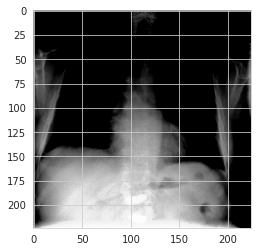

In [36]:
imageSet0 = trainUNetDataGen[1][0][1]
plt.imshow(imageSet0)

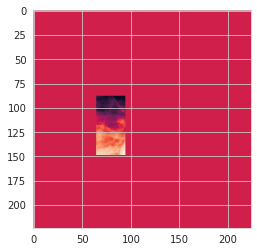

In [37]:
## Masks for the same
imageSet0 = trainUNetDataGen[2][0]
maskSet0 = trainUNetDataGen[2][1]    
showMaskedImage(imageSet0, maskSet0, 5)

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization ,Conv2DTranspose
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet , VGG19
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K
from PIL import Image
from numpy import asarray
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.layers import Concatenate, UpSampling2D, Conv2D, Reshape, GlobalAveragePooling2D

In [26]:
LR = 1e-4
ALPHA = 1.0
def create_UNetModelUsingMobileNet(trainable=True):
    """Function to create UNet architecture with MobileNet.
        
    Arguments:
        trainable -- Flag to make layers trainable. Default value is 'True'.
    """
    # Get all layers with 'imagenet' weights
    model = MobileNet(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA, weights="imagenet") 
    # Top layer is last layer of the model
    
    # Make all layers trainable
    for layer in model.layers:
        layer.trainable = trainable

    # Add all the UNET layers here
    convLayer_112by112 = model.get_layer("conv_pw_1_relu").output
    convLayer_56by56 = model.get_layer("conv_pw_3_relu").output
    convLayer_28by28 = model.get_layer("conv_pw_5_relu").output
    convLayer_14by14 = model.get_layer("conv_pw_11_relu").output
    convLayer_7by7 = model.get_layer("conv_pw_13_relu").output
    # The last layer of mobilenet model is of dimensions (7x7x1024)

    # Start upsampling from 7x7 to 14x14 ...up to 224x224 to form UNET
    # concatinate with the original image layer of the same size from MobileNet
    x = Concatenate()([UpSampling2D()(convLayer_7by7), convLayer_14by14])
    x = Concatenate()([UpSampling2D()(x), convLayer_28by28])
    x = Concatenate()([UpSampling2D()(x), convLayer_56by56])
    x = Concatenate()([UpSampling2D()(x), convLayer_112by112])
    x = UpSampling2D(name="unet_last")(x) # upsample to 224x224

    # Add classification layer
    x = Conv2D(1, kernel_size=1, activation="sigmoid", name="masks")(x)
    x = Reshape((IMAGE_SIZE, IMAGE_SIZE))(x) 

    return Model(inputs=model.input, outputs=x)


In [27]:
## Build a model 
input_shape = (IMAGE_SIZE,IMAGE_SIZE,3)
model = create_UNetModelUsingMobileNet(input_shape)
model.summary()

17235968/17225924 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 32  128         ['conv1[0][0]']                  
                             

In [28]:
#dice_coef 2 * the Area of Overlap divided by the total number of pixels in both images
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + tf.keras.backend.epsilon()) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + tf.keras.backend.epsilon())

## Loss is 1 - the coefficent of two images
def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)


In [29]:
## Call Backs for ealy stopping and reduce learning rate 
## Reduce the learning rate when teh validation loss is same for 4 epocs
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [30]:
## Optimiser , metrics and loss for the model
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [38]:
## Running the model
train_steps = len(trainUNetDataGen)//BATCH_SIZE
valid_steps = len(validateUNetDataGen)//BATCH_SIZE

if len(trainUNetDataGen) % BATCH_SIZE != 0:
    train_steps += 1
if len(validateUNetDataGen) % BATCH_SIZE != 0:
    valid_steps += 1


history = model.fit(trainUNetDataGen,
                        epochs=20,
                        steps_per_epoch=train_steps,
                        validation_data=validateUNetDataGen,
                        callbacks=callbacks,
                        use_multiprocessing=True,
                        workers=4,
                        validation_steps=valid_steps,                      
                        shuffle=True)


Epoch 1/20
60/60 [==============================] - 435s 7s/step - loss: 0.7312 - dice_coef: 0.2688 - recall: 0.4940 - precision: 0.2289 - val_loss: 0.9167 - val_dice_coef: 0.0833 - val_recall: 0.1964 - val_precision: 0.0979 - lr: 1.0000e-04
Epoch 2/20
60/60 [==============================] - 445s 7s/step - loss: 0.6731 - dice_coef: 0.3269 - recall: 0.5160 - precision: 0.2968 - val_loss: 0.8822 - val_dice_coef: 0.1178 - val_recall: 0.4955 - val_precision: 0.1107 - lr: 1.0000e-04
Epoch 3/20
60/60 [==============================] - 429s 7s/step - loss: 0.6842 - dice_coef: 0.3158 - recall: 0.4885 - precision: 0.2750 - val_loss: 0.8813 - val_dice_coef: 0.1187 - val_recall: 0.4943 - val_precision: 0.0957 - lr: 1.0000e-04
Epoch 4/20
60/60 [==============================] - 447s 7s/step - loss: 0.6630 - dice_coef: 0.3370 - recall: 0.5028 - precision: 0.3062 - val_loss: 0.8851 - val_dice_coef: 0.1149 - val_recall: 0.5795 - val_precision: 0.0939 - lr: 1.0000e-04
Epoch 5/20
60/60 [==============

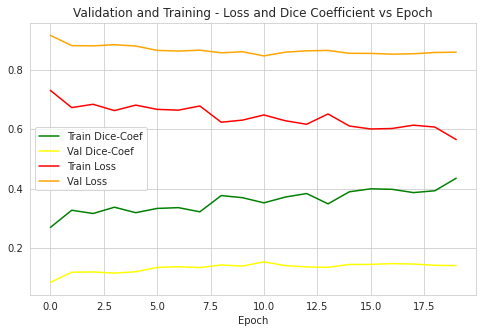

In [39]:
## PLot Matrix between training and validation data
plt.figure(figsize=(8, 5))
plt.grid(True)
plt.plot(history.history['dice_coef'],     label='Train Dice-Coef',      color = "green" );
plt.plot(history.history['val_dice_coef'], label='Val Dice-Coef',  color = "yellow");
plt.plot(history.history['loss'],         label='Train Loss',          color = "red"   );
plt.plot(history.history['val_loss'],     label='Val Loss',      color = "orange");
plt.title("Validation and Training - Loss and Dice Coefficient vs Epoch")
plt.xlabel("Epoch")
plt.legend();

The performance can further be improved using the original resolution and hyperparameter tuning.

In [42]:
##Preparing test data , picked up random 5 images
test_Data = merged_df[12000:12020]
test_Data.Target.value_counts()

0    15
1     5
Name: Target, dtype: int64

In [43]:
## Setting the custom generator for test data
testUNetDataGen = TrainGenerator(test_Data)

In [44]:
## evaluating the model
test_steps = (len(testUNetDataGen)//BATCH_SIZE)
if len(testUNetDataGen) % BATCH_SIZE != 0:
    test_steps += 1

model.evaluate(testUNetDataGen)

2/2 [==============================] - 5s 2s/step - loss: 0.6935 - dice_coef: 0.3065 - recall: 0.8129 - precision: 0.1784


[0.6934551000595093,
 0.3065448999404907,
 0.8128776550292969,
 0.1783839762210846]

In [45]:
pred_mask = model.predict(testUNetDataGen)

In [46]:
test_Data = test_Data.reset_index()

In [48]:
from sklearn.metrics import confusion_matrix
y_pred = []
y_True = []
imageList = []
predMaskTemp = []
IMAGE_HEIGHT = 224
IMAGE_WIDTH = 224
def getPredictions(test_Data):
    masks = np.zeros((int(test_Data.shape[0]), IMAGE_HEIGHT, IMAGE_WIDTH))

    for index, row in test_Data.iterrows():
        patientId = row.patientId
        classlabel = row["Target"]
        dcm_file = '/content/drive/MyDrive/Colab/capstoneCV1/data/stage_2_train_images/'+'{}.dcm'.format(patientId)
        dcm_data = pydicom.read_file(dcm_file)
        img = dcm_data.pixel_array
        resized_img = cv2.resize(img,(IMAGE_HEIGHT,IMAGE_WIDTH), interpolation = cv2.INTER_LINEAR)
        predMaskTemp.append(pred_mask[index])
        iou = (pred_mask[index] > 0.5) * 1.0
        y_pred.append((1 in iou) * 1)
        imageList.append(resized_img)
        y_True.append(classlabel)
        x_scale = IMAGE_HEIGHT / 1024
        y_scale = IMAGE_WIDTH / 1024

        if(classlabel == 1):
            x = int(np.round(row['x'] * x_scale))
            y = int(np.round(row['y'] * y_scale))
            w = int(np.round(row['width'] * x_scale))
            h = int(np.round(row['height'] * y_scale))
            masks[index][y:y+h, x:x+w] = 1

        
        
    tmpImages = np.array(imageList)
    tmpMask = np.array(predMaskTemp)
    originalMask = np.array(masks)
    return (y_True,y_pred,tmpImages,tmpMask ,originalMask)
    
def print_confusion_matrix(y_true, y_pred):
    '''Function to print confusion_matrix'''

    # Get confusion matrix array
    array = confusion_matrix(y_true, y_pred)    
    df_cm = pd.DataFrame(array, range(2), range(2))

    print("Total samples = ", len(test_Data))

    # Plot heatmap and get sns heatmap values
    sns.set(font_scale=1.4); # for label size
    result = sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g', cbar=False); 

    # Add labels to heatmap
    labels = ['TN=','FP=','FN=','TP=']
    i=0
    for t in result.texts:
        t.set_text(labels[i] + t.get_text())
        i += 1
    
    plt.xlabel("Predicted Values")
    plt.ylabel('True Values')
    plt.show()
    return


In [49]:
y_true,y_pred ,imagelist , maskList , originalMask = getPredictions(test_Data)

Text(0.5, 0, 'Pneumonia 0:')

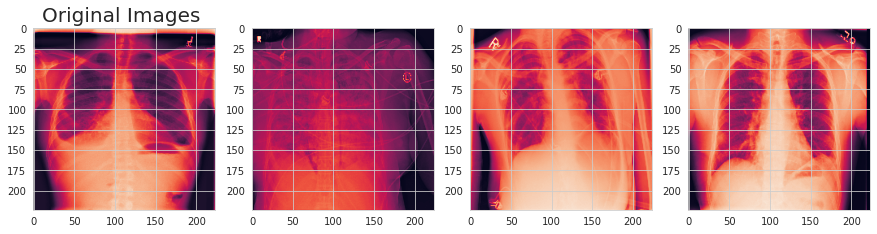

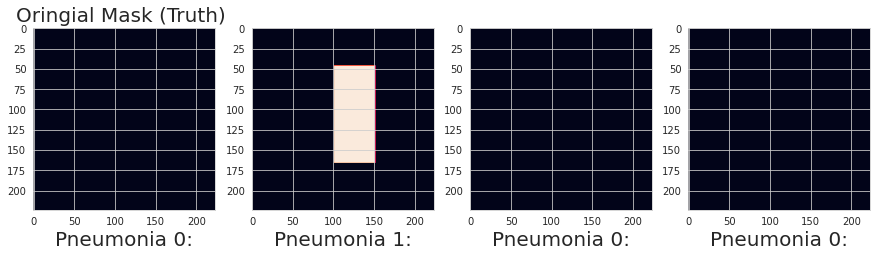

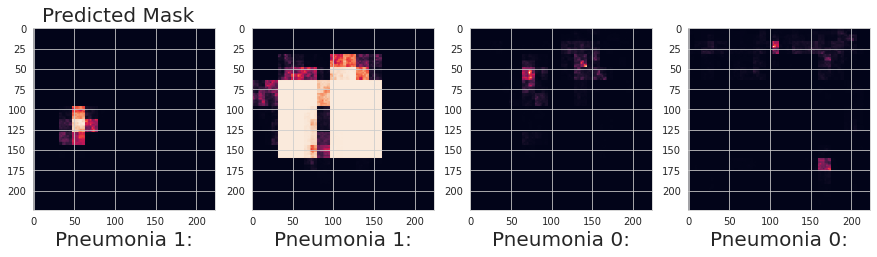

In [50]:
## Visualising the train and output data 
##
fig = plt.figure(figsize=(15, 15))

a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(imagelist[1])
a.set_title('Original Images ',fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(imagelist[12])

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(imagelist[13])

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(imagelist[15])


fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)

imgplot = plt.imshow(originalMask[1])
a.set_title('Oringial Mask (Truth) ',fontsize=20)

a.set_xlabel('Pneumonia {}:'.format(y_true[1]), fontsize=20)


a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(originalMask[12])
a.set_xlabel('Pneumonia {}:'.format(y_true[12]), fontsize=20)


a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(originalMask[13])
a.set_xlabel('Pneumonia {}:'.format(y_true[13]), fontsize=20)


a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(originalMask[15])
a.set_xlabel('Pneumonia {}:'.format(y_true[15]), fontsize=20)
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
a.set_title('Predicted Mask  ',fontsize=20)
imgplot = plt.imshow(maskList[1])
a.set_xlabel('Pneumonia {}:'.format(y_pred[1]), fontsize=20)

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(maskList[12])
a.set_xlabel('Pneumonia {}:'.format(y_pred[12]), fontsize=20)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(maskList[13])
a.set_xlabel('Pneumonia {}:'.format(y_pred[13]), fontsize=20)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(maskList[15])
a.set_xlabel('Pneumonia {}:'.format(y_pred[15]), fontsize=20)


Total samples =  20


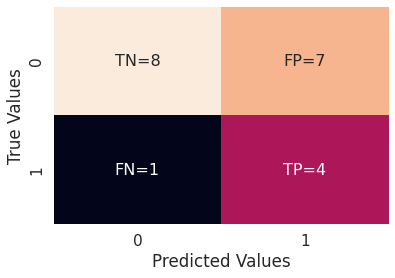

In [51]:
print_confusion_matrix(y_true,y_pred )

In [52]:
from sklearn.metrics import classification_report

print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.89      0.53      0.67        15
           1       0.36      0.80      0.50         5

    accuracy                           0.60        20
   macro avg       0.63      0.67      0.58        20
weighted avg       0.76      0.60      0.63        20

